In [1]:
import pandas as pd
import numpy

In [2]:
import spacy

In [3]:
nlp = spacy.load("en")

In [4]:
# def tokenize(x):
#     return nlp(x, parse=False, tag=False, entity=False)

def tokenize(x):
    return x.strip().split(' ')

In [5]:
data_file = 'data/wikitext-2/train.txt'
#data_file = 'data/tel.wx.txt'

In [6]:
def load_file(file_name):
    with open(data_file) as d:
        for line in d:
            yield tokenize(line)
        

In [7]:
f = load_file(data_file)

In [8]:
# def get_tokens(file):
#     tokens = {}
#     for sent in file:
#         for token in sent:
#             try:
#                 tokens[token.text] += 1
#             except:
#                 tokens[token.text] = 1
#     return tokens

def get_tokens(file):
    tokens = {}
    for sent in file:
        for token in sent:
            try:
                tokens[token] += 1
            except:
                tokens[token] = 1
    return tokens


In [9]:
%%time 
tokens = get_tokens(f)
print(len(tokens))

33278
CPU times: user 360 ms, sys: 979 µs, total: 361 ms
Wall time: 352 ms


In [10]:
import math
def norm_probs(tokens):
    s = sum(tokens.values())
    return {k : round(math.log(v/float(s)),4) for k, v in tokens.items()}
def sort_probs(probs):
    return sorted(probs.items(), key=lambda x:x[1], reverse=True)

In [11]:
probs = norm_probs(tokens)
sorted_probs = sort_probs(probs)

In [12]:
sorted_probs[1000:2000]

[('cut', -9.2274),
 ('constructed', -9.2323),
 ('Sun', -9.2323),
 ('contains', -9.2323),
 ('fleet', -9.2323),
 ('summer', -9.2373),
 ('media', -9.2373),
 ('1999', -9.2373),
 ('word', -9.2423),
 ('money', -9.2423),
 ('Hill', -9.2423),
 ('cover', -9.2423),
 ('contract', -9.2423),
 ('Port', -9.2423),
 ('effects', -9.2423),
 ('majority', -9.2473),
 ('listed', -9.2473),
 ('poor', -9.2473),
 ('nature', -9.2473),
 ('voice', -9.2473),
 ('ranked', -9.2473),
 ('business', -9.2473),
 ('Council', -9.2473),
 ('stories', -9.2473),
 ('experience', -9.2523),
 ('create', -9.2523),
 ('musical', -9.2523),
 ('research', -9.2523),
 ('But', -9.2523),
 ('No', -9.2523),
 ('45', -9.2523),
 ('Galveston', -9.2523),
 ('leaving', -9.2574),
 ('station', -9.2574),
 ('critical', -9.2574),
 ('dam', -9.2574),
 ('professional', -9.2625),
 ('thus', -9.2625),
 ('makes', -9.2625),
 ('primary', -9.2625),
 ('Parliament', -9.2625),
 ('Jewish', -9.2625),
 ('location', -9.2676),
 ('turn', -9.2676),
 ('always', -9.2676),
 ('live

In [13]:
pruned_probs = dict(sorted_probs)

In [14]:
import nltk

In [18]:
def get_ngrams(tokens, min_length = 5, max_N=4):
    for token, freq in tokens:
        if len(token) >= min_length:
            splits = []
            for i in range(1, max_N+1):
                splits += list([''.join(x) for x in nltk.ngrams(list(token), i)])
            yield token, splits

In [19]:
for x in get_ngrams([('apples',2)]):
    print(x)

('apples', ['a', 'p', 'p', 'l', 'e', 's', 'ap', 'pp', 'pl', 'le', 'es', 'app', 'ppl', 'ple', 'les', 'appl', 'pple', 'ples'])


In [20]:
%%time
all_splits = {}
for token, splits in get_ngrams(sorted_probs, max_N=4):
   # all_splits[token] = get_pos_encoded(len(token), splits)
    for split in splits:
        if split not in all_splits:
            all_splits[split] = {}
        if token in pruned_probs:
            if token not in all_splits[split]:
                all_splits[split][token] = 0
            all_splits[split][token] += 1

CPU times: user 724 ms, sys: 1.66 ms, total: 725 ms
Wall time: 728 ms


In [21]:
word_list = list(pruned_probs.keys())
word2index = lambda w : word_list.index(w)
index2word = lambda i : word_list[i]

In [22]:
list(all_splits.items())[:5]

[('<', {'<unk>': 1, '<formula>': 1}),
 ('u',
  {'<unk>': 1,
   'would': 1,
   'during': 1,
   'about': 1,
   'album': 1,
   'through': 1,
   'including': 1,
   'number': 1,
   'century': 1,
   'under': 1,
   'found': 1,
   'could': 1,
   'until': 1,
   'because': 1,
   'around': 1,
   'August': 2,
   'music': 1,
   'South': 1,
   'During': 1,
   'included': 1,
   'January': 1,
   'although': 1,
   'group': 1,
   'built': 1,
   'south': 1,
   'published': 1,
   'continued': 1,
   'without': 1,
   'though': 1,
   'public': 1,
   'support': 1,
   'Although': 1,
   'further': 1,
   'League': 1,
   'February': 1,
   'church': 1,
   'Church': 1,
   'produced': 1,
   'production': 1,
   'include': 1,
   'returned': 1,
   'population': 1,
   'country': 1,
   'throughout': 2,
   'result': 1,
   'thought': 1,
   'using': 1,
   'Australia': 1,
   'previous': 1,
   'various': 1,
   'County': 1,
   'building': 1,
   'caused': 1,
   'should': 1,
   'construction': 1,
   'announced': 1,
   'Australia

In [23]:
%%time
#split_matrix = numpy.ndarray((len(all_splits), len(pruned_probs)))
split_matrix = numpy.memmap('split_matrix.en.dat', dtype='float32', mode='w+', shape=(len(all_splits), len(pruned_probs)))
for si, split in enumerate(all_splits):
    #print(split)
    split_matrix[si] = 0
    for word, count in all_splits[split].items():
        wi = word2index(word)
        #print(word, wi)
        split_matrix[si, wi] = count
        
    

CPU times: user 2min 11s, sys: 1.97 s, total: 2min 13s
Wall time: 2min 19s


In [25]:
split_matrix = numpy.memmap('split_matrix.en.dat', dtype='float32', mode='r')


In [26]:
a, b = len(all_splits), len(pruned_probs)
a, b, a * b, split_matrix.shape, split_matrix.shape[0] / a
split_matrix = split_matrix.reshape(a, int(split_matrix.shape[0] / a ))

In [27]:
split_list = list(all_splits.keys())
split2index = lambda w : split_list.index(w)
index2split = lambda i : split_list[i]
split2vec = lambda s : split_matrix[split2index(s)]

In [28]:
split2vec('ma')

memmap([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [29]:
def delta_p(x, y):
    try:
        xi, yi = split2index(x), split2index(y)
    except Exception as e:
        #print(e)
        return numpy.NINF
    xp, yp = split_matrix[xi], split_matrix[yi]
    xpne, ypne = xp > 0, yp > 0
    cyp = ypne.sum()
    cxpyp = ((xpne) & (ypne)).sum()
    if cyp != 0:
        del_p = cxpyp/float(cyp)
    else:
        del_p = 0
    
    #print(del_p, cyp, cxpyp)
    if del_p > 0:
        del_p = -math.log(del_p)
    else:
        del_p = numpy.NINF
    
    ype = (yp == 0)
    cype = ype.sum()
    cxpype = ((xpne) & (ype)).sum()
    if cype != 0:
        del_p2 = cxpype / float(cype)
        if del_p2 != 0:                  
            del_p = del_p + math.log(del_p2)
    #print(del_p)
    return del_p
    #return -math.log(abs(del_p))
    

In [30]:
def run_sequence(sequence):
    scores = []
    for s in range(1, len(sequence)):
        x, y = sequence[s - 1], sequence[s]
        try:
            scores.append(delta_p(x, y))
        except Exception as e:
            print(e.with_traceback())
            pass
    return scores, sum(scores) / len(sequence)

In [31]:
#sorted_probs[40000:45000]

In [35]:
def walk_paths(pos_dict, rem, pos = 0):
    if rem == 0:
        return None
    if pos not in pos_dict:
        return None
    paths = []
    for split, p in pos_dict[pos]:
        if p[1] + 1 not in pos_dict:
            path = []
            path.append((split,p))
            paths.append(path)
            
        else:
            rem_path = walk_paths(pos_dict, rem = rem - p[1], pos = p[1] + 1)
            if rem_path:
                for r in rem_path:
                    paths.append([(split, p)] + r)
        
        
    return paths

from pprint import pprint
def get_split_sequences(token, max_N=4):
    splits = []
    for i in range(1, max_N+1):
        splits += list([(''.join(x), (j, j+i-1)) for j, x in enumerate(nltk.ngrams(list(token), i))])
    s_pos_dict = {}
    
    for split, pos in splits:
        if pos[0] not in s_pos_dict:
            s_pos_dict[pos[0]] = []
        s_pos_dict[pos[0]].append((split, pos))
    
    all_paths  = walk_paths(s_pos_dict, len(token), 0)
    paths = []
    for path in all_paths:
        if path[-1][1][1] == len(token) - 1:
            paths.append([x[0] for x in path])
    
    return paths

In [36]:
def score_sequences(sequences):
    scores = []
    for seq in sequences:
        score_f = run_sequence(seq)
        score_r= run_sequence(seq[::-1])
        score = (score_f[1] + score_r[1])/2
        scores.append(score)
    return scores


In [37]:
sequences = get_split_sequences('apples',max_N=4)
sequences

[['a', 'p', 'p', 'le', 's'],
 ['a', 'p', 'p', 'les'],
 ['a', 'p', 'pl', 'e', 's'],
 ['a', 'p', 'pl', 'es'],
 ['a', 'p', 'ple', 's'],
 ['a', 'p', 'ples'],
 ['a', 'pp', 'l', 'e', 's'],
 ['a', 'pp', 'l', 'es'],
 ['a', 'pp', 'les'],
 ['a', 'ppl', 'e', 's'],
 ['a', 'ppl', 'es'],
 ['a', 'pple', 's'],
 ['ap', 'p', 'le', 's'],
 ['ap', 'p', 'les'],
 ['ap', 'pl', 'e', 's'],
 ['ap', 'pl', 'es'],
 ['ap', 'ple', 's'],
 ['ap', 'ples'],
 ['app', 'l', 'e', 's'],
 ['app', 'l', 'es'],
 ['app', 'les'],
 ['appl', 'e', 's'],
 ['appl', 'es']]

In [38]:
scores = score_sequences(sequences) 
#scores
scores.index(max(scores))


5

In [39]:
sequences[5], scores[5]

(['a', 'p', 'ples'], 0.5261872700356867)

In [41]:
import copy
vowels = ['a', 'A', 'e', 'E', 'i', 'I', 'o', 'O', 'u', 'U']
words = copy.deepcopy(word_list)
#mport random 
#andom.shuffle(words)

In [42]:
words = [w for w in words if len(w) > 6]

In [43]:
words

['between',
 'through',
 'including',
 'against',
 'century',
 'several',
 'episode',
 'American',
 'British',
 'released',
 'because',
 'million',
 'However',
 'September',
 'following',
 'received',
 'described',
 'October',
 'species',
 'another',
 'included',
 'January',
 'England',
 'although',
 'November',
 'December',
 'government',
 'character',
 'original',
 'National',
 'history',
 'considered',
 'recorded',
 'company',
 'published',
 'continued',
 'English',
 'without',
 'written',
 'support',
 'release',
 'Division',
 'Although',
 'however',
 'further',
 'version',
 'According',
 'military',
 'different',
 'February',
 'produced',
 'production',
 'tropical',
 'children',
 'similar',
 'include',
 'members',
 'position',
 'control',
 'reported',
 'General',
 'returned',
 'University',
 'America',
 'established',
 'population',
 'country',
 'reached',
 'Ireland',
 'developed',
 'throughout',
 'thought',
 'himself',
 'development',
 'Australia',
 'performed',
 'writing',
 'tele

In [44]:
%%time
patterns = {}
for w in words[:500]:
    splits = get_split_sequences(w)
    scores = score_sequences(splits)
    max_split = splits[scores.index(max(scores))]
    for s in max_split:
        pat = ''.join(['v' if x in vowels else 'c' for x in s])
        if pat not in patterns:
            patterns[pat] = 0
        patterns[pat] += 1      

/home/nesh/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


TypeError: with_traceback() takes exactly one argument (0 given)

In [48]:
sorted(patterns.items(), key = lambda x : x[1], reverse=True)

[('cv', 760),
 ('vc', 273),
 ('cvc', 196),
 ('cc', 132),
 ('ccv', 104),
 ('vcv', 97),
 ('cvcc', 45),
 ('cvcv', 39),
 ('vcc', 27),
 ('vccv', 21),
 ('ccvc', 16),
 ('vcvc', 9),
 ('vccc', 5),
 ('cccv', 3),
 ('ccc', 3),
 ('cccc', 2)]

In [45]:
def get_max_split(w):
    splits = get_split_sequences(w)
    scores = score_sequences(splits)
    max_split = splits[scores.index(max(scores))]
    return max_split

In [47]:
get_max_split('apples')

['a', 'p', 'ples']

In [48]:
import random
random.shuffle(words)
sample_words = words[:1000]

In [49]:
%%time
max_splits = {}
for i, w in enumerate(sample_words):
    try:
        sp = get_max_split(w)
        max_splits[w] = sp
        if i % 100 == 0:
            print(f"{i} done")
    except:
        pass

0 done


/home/nesh/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
CPU times: user 34min 28s, sys: 307 ms, total: 34min 28s
Wall time: 34min 32s


In [50]:
max_splits

{'corporations': ['c', 'o', 'rpo', 'r', 'a', 'tion', 's'],
 'Cooperation': ['Coop', 'e', 'ra', 'tion'],
 'photographers': ['p', 'h', 'otog', 'r', 'aphe', 'r', 's'],
 'consequence': ['c', 'o', 'nseq', 'u', 'enc', 'e'],
 'Scientology': ['Scie', 'n', 't', 'o', 'logy'],
 'Chronicle': ['Chr', 'o', 'nicl', 'e'],
 'regulated': ['re', 'g', 'ul', 'a', 'ted'],
 'housekeeper': ['h', 'o', 'usek', 'e', 'eper'],
 'Harrington': ['Har', 'r', 'i', 'ngto', 'n'],
 'dancers': ['d', 'anc', 'ers'],
 'Carlock': ['C', 'a', 'rloc', 'k'],
 'resolved': ['res', 'o', 'lved'],
 'Directing': ['Dire', 'c', 'ting'],
 'civilians': ['civ', 'i', 'lian', 's'],
 'depressed': ['depr', 'e', 'ssed'],
 'urgently': ['ur', 'g', 'e', 'n', 't', 'ly'],
 'Fortune': ['F', 'o', 'rtun', 'e'],
 'recordings': ['reco', 'r', 'ding', 's'],
 'Lochaber': ['Loch', 'a', 'ber'],
 'populace': ['popu', 'l', 'ace'],
 'District': ['Dis', 't', 'rict'],
 'concentrated': ['c', 'once', 'n', 't', 'rate', 'd'],
 'contents': ['co', 'n', 'tent', 's'],
 'fix

In [41]:
%%time
sorted_probs = sort_probs(probs)
pruned_probs = dict(sorted_probs)
word_list = list(pruned_probs.keys())
word_list_len = len(word_list)
index_array = numpy.array(list(range(len(word_list))))
ratios = {}
for index, split in enumerate(split_list):
    split_vec = split2vec(split)
    select_w = split_vec.nonzero()
    in_deg = len(select_w[0])
    #print(split_vec.nonzero())
    #print(split, in_deg, select_w)
    out_deg = 0
    for wi in select_w[0]:
        w = word_list[wi]        
        if w in max_splits:
            wsplit = max_splits[w]
            if split in wsplit:
                out_deg += 1

        
#        print(split, w, wsplit, split in wsplit)
    #ratio = float(in_deg)/out_deg if out_deg > 0 else 0
    #ratio = 1 - (out_deg/float(in_deg))
    ratio = out_deg * (in_deg/float(word_list_len))
    ratios[split] = ratio
    if index % 1000 == 0:
        print(f"{index} done")
    
    

0 done
1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
11000 done
12000 done
13000 done
14000 done
15000 done
16000 done
17000 done
18000 done
19000 done
20000 done
21000 done
22000 done
23000 done
24000 done
25000 done
26000 done
27000 done
28000 done
29000 done
30000 done
31000 done
32000 done
33000 done
34000 done
35000 done
36000 done
37000 done
38000 done
39000 done
40000 done
41000 done
42000 done
43000 done
44000 done
45000 done
46000 done
47000 done
48000 done
49000 done
50000 done
51000 done
52000 done
53000 done
54000 done
55000 done
56000 done
57000 done
58000 done
59000 done
60000 done
61000 done
62000 done
63000 done
64000 done
65000 done
66000 done
67000 done
68000 done
69000 done
70000 done
71000 done
72000 done
73000 done
74000 done
75000 done
76000 done
77000 done
78000 done
79000 done
80000 done
81000 done
82000 done
83000 done
84000 done
85000 done
86000 done
87000 done
88000 done
89000 done
90000 done
91000 done
9

In [42]:
ratios = pd.Series(ratios)

In [43]:
ratios.count()

106630

In [45]:
ratios[ratios > 0].count()


226

In [46]:
p_ratios = ratios[ratios > 0].sort_values()


In [48]:
#p_ratios['es'],p_ratios['ies']
p_glens = p_ratios.index.str.len()

In [49]:
p_glens.value_counts()

2    139
3     65
4     22
dtype: int64

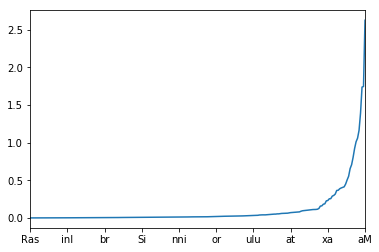

In [50]:
%matplotlib inline
p_ratios.plot()

In [51]:
w = 'samayAniki'
sequences = get_split_sequences(w)
sequences

[['sa', 'ma', 'yA', 'ni', 'ki'],
 ['sa', 'ma', 'yA', 'niki'],
 ['sa', 'ma', 'yAni', 'ki'],
 ['sa', 'may', 'An', 'iki'],
 ['sa', 'may', 'Ani', 'ki'],
 ['sa', 'mayA', 'ni', 'ki'],
 ['sa', 'mayA', 'niki'],
 ['sam', 'ay', 'An', 'iki'],
 ['sam', 'ay', 'Ani', 'ki'],
 ['sam', 'ayA', 'ni', 'ki'],
 ['sam', 'ayA', 'niki'],
 ['sam', 'ayAn', 'iki'],
 ['sama', 'yA', 'ni', 'ki'],
 ['sama', 'yA', 'niki'],
 ['sama', 'yAn', 'iki']]

In [52]:
get_max_split(w)

['sa', 'ma', 'yA', 'niki']

In [84]:
def run_sequence_f(sequence, good_splits):
    scores = []
    new_sequence = []
    #print(sequence)
    for s in range(1, len(sequence)):
        x, y = sequence[s - 1], sequence[s]
        #print(x, y)
        if (x in good_splits) and (y in good_splits):
            #print(x, y)
            try:
                scores.append(delta_p(x, y))
            except Exception as e:
                print(e.with_traceback())
                
            new_sequence.append(x)
        else:
            #print((x in good_splits), (y in good_splits), x, y, new_sequence)
            
            if y not in good_splits:
                if len(new_sequence) == 0:                
                    new_sequence.append(x + y)
                elif (x in good_splits):
                    if new_sequence[-1].endswith(x):
                        new_sequence[-1] += y
                    else:
                        new_sequence.append(x + y)
                    
                else:
                    new_sequence[-1] += y
                    
            elif x not in good_splits:                         
                if len(new_sequence) == 0:
                    new_sequence.append(x + y)
                else:
                    new_sequence.append(y)
                
                split_vec = split2vec(y)
                select_w = split_vec.nonzero()
                in_deg = len(select_w[0])
                scores.append(good_splits[y]/in_deg)
                
    #print(new_sequence)
    if not new_sequence[-1].endswith(sequence[-1]):
        new_sequence.append(sequence[-1])
        
    return new_sequence, scores, sum(scores) / len(sequence)


def score_sequences_f(sequences,good_splits):
    scores = []
    new_seqs = []
    for seq in sequences:
        new_seq_f, _, score_f = run_sequence_f(seq, good_splits)
        new_seq_r, _, score_r= run_sequence_f(seq[::-1], good_splits)
        new_seq_r = new_seq_r[::-1]
        new_seq = new_seq_f if score_f > score_r else new_seq_r
        new_seqs.append(new_seq_f)
#        score = score_f
        score = (score_f + score_r)/2
        scores.append(score)
    return new_seqs, scores

def get_max_split_f(w, good_splits):
    splits = get_split_sequences(w)
    new_splits, scores = score_sequences_f(splits, good_splits)
    max_index = scores.index(max(scores))
    #print(max_index)
    max_split = new_splits[max_index]
    return max_split, max(scores)

In [86]:
#score_sequences_f(sequences, p_ratios)
get_max_split_f('nirNayiMcukogala', p_ratios)
# for k in sequences:
#     print('-'*5)
#     print(k)
#     print(run_sequence_f(k, p_ratios))

(['nirNay', 'iMcukoga', 'la'], 2.2524995706172695e-05)

In [242]:
run_sequence_f(['in', 'it', 'iali', 'zati', 'on'], p_ratios)

in it
it iali
True False it iali ['in']
iali zati
False False iali zati ['in', 'itiali']
zati on
False True zati on ['in', 'itializati']


(['in', 'itializati', 'on'],
 [0.03913968974847393, 0.020425967149990978],
 0.011913131379692982)

In [87]:
%%time
max_splits = {}
for i, w in enumerate(sample_words):
    try:
        sp = get_max_split_f(w, p_ratios)
        max_splits[w] = sp
        if i % 1000 == 0:
            print(f"{i} done")
    except:
        pass

0 done
CPU times: user 5min 5s, sys: 167 ms, total: 5min 5s
Wall time: 5min 14s


In [88]:
max_splits

{'nunnAru': (['nunnA', 'ru'], 1.267031008472214e-05),
 'moyadaM': (['mo', 'yadaM'], 0.11386912407101377),
 'vaMgilekapovadaM': (['va', 'Mgilekapov', 'adaM'], 0.016998523027387503),
 'maguvalaku': (['ma', 'gu', 'valaku'], 0.18124513300621076),
 'veVlYlYakuMdA': (['veVlYlYa', 'kuMdA'], 1.4782028432175829e-05),
 'kAmAMXurAligA': (['kAmAMXu', 'rA', 'rA', 'li', 'gA'], 0.022514482363229692),
 'vIdkoVlipAdu': (['vIdkoV', 'koV', 'lipAdu'], 0.014902992249798942),
 'AnupAnulu': (['AnupAn', 'An', 'ulu'], 0.15906712299221093),
 'gArdeVns': (['gArd', 'eVns'], 1.9005465127083213e-05),
 'sureR\u200cku': (['sureR\u200c', 'ku'], 1.1262497853086346e-05),
 'vrawAnni': (['vrawAn', 'ni'], 1.4078122316357932e-05),
 'vaMSAniki': (['vaMSA', 'niki'], 2.9564056864351657e-05),
 'bayograPI': (['bayog', 'raPI'], 2.0061324300810052e-05),
 'galavAriwo': (['galavA', 'ri', 'ri', 'wo'], 0.044113975449023006),
 'guddipeVlYlAnni': (['guddip', 'eVlYlA', 'nni'], 1.4359684762685095e-05),
 'vismayAniki': (['vismayA', 'niki']